In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor

from yellowbrick.cluster import silhouette_visualizer

import warnings
warnings.filterwarnings("ignore")

**1. Подготовим данные**

In [19]:
df = pd.read_excel('rfm_data.xlsx')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417495 entries, 0 to 417494
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             417495 non-null  datetime64[ns]
 1   user_session_id  417495 non-null  object        
 2   cnt_help_pages   417495 non-null  int64         
 3   user_company_id  417495 non-null  object        
 4   user_client_id   417495 non-null  object        
 5   user_role        417495 non-null  object        
 6   theme            342135 non-null  object        
 7   cnt_tickets      416684 non-null  float64       
 8   amount           416684 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 28.7+ MB


**a. Заменим null на 0 и на строку "Не определена"**

In [21]:
df['theme'] = df['theme'].fillna('Не определена')
df['cnt_tickets'] = df['cnt_tickets'].fillna(0)
df['amount'] = df['amount'].fillna(0)

**б. Приведём данные к нужному формату** 

In [22]:
df['date'] = df['date'].dt.date
df['cnt_tickets'] = df['cnt_tickets'].astype('int64')
df['amount'] = df['amount'].astype('int64')

In [23]:
print('Данные за период: от {} до {}'.format(df['date'].min(), df['date'].max()))
print('Количество уникальных пользователей: {}'.format(df['user_client_id'].nunique()))
print('Количество уникальных компаний: {}'.format(df['user_company_id'].nunique()))
print('Количество заходов в раздел Помощь: {}'.format(len(df)))
print('Количество сообщений в поддержку: {}'.format(df['cnt_tickets'].sum()))
print('Сумма, потраченная на поддержку : {} руб.'.format(df['amount'].sum()))

Данные за период: от 2022-06-15 до 2022-08-31
Количество уникальных пользователей: 84541
Количество уникальных компаний: 80540
Количество заходов в раздел Помощь: 417495
Количество сообщений в поддержку: 1286610
Сумма, потраченная на поддержку : 128661000 руб.


**2. Вычислим и визуализируем метрики RFM: recency, frequency, monetary**
При расчёте метрики monetary мы берем среднюю сумму, которую генерит пользователь обращениями в поддержку ("средний чек").

In [24]:
max_date = df['date'].max() + dt.timedelta(days=1)
df_rfm = df.groupby('user_client_id').agg({'date': lambda x: (max_date - x.max()).days, 
                                           'user_company_id': 'count',
                                           'amount': 'mean'})
df_rfm.columns=['recency', 'frequency', 'monetary']

In [25]:
df_rfm

,recency,frequency,monetary
user_client_id,,,
0001f3785a0a25569cde27e7f28f79dba66ca222,30,4,375.0
000243ad0488a501cd994670cc12fa7ae4edcde9,28,5,160.0
00026c5cdb25e2b03e3ce2f966614c026024a86b,10,8,212.5
000292735f714ba59c54d293f5725b32fbd91b7c,21,1,200.0
000297d8792259c0d1068ad4aa7abf8a200b8806,51,1,100.0
...,...,...,...
fffc450c8d9a7e5ab49c6653ae820908a59373df,8,2,200.0
fffe04bb9366c0759a7ce6b807f6c737acb01e47,1,2,100.0
fffea59299f17b952db19dbd3e2a34c889ac4751,9,2,950.0


<AxesSubplot:xlabel='recency', ylabel='Density'>

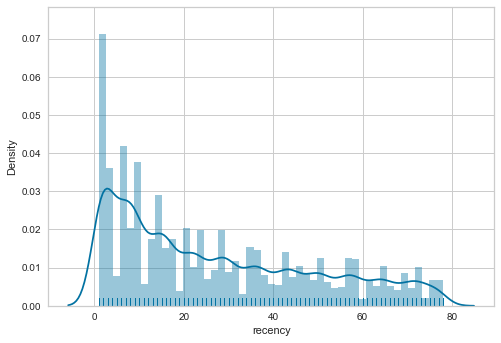

In [26]:
sns.distplot(df_rfm['recency'], hist=True, rug=True)

Метрика Recency дискретная, без выбросов

<AxesSubplot:xlabel='frequency', ylabel='Density'>

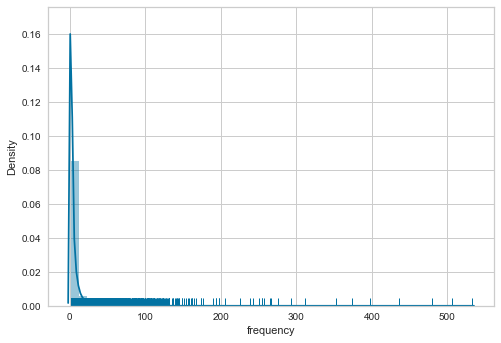

In [27]:
sns.distplot(df_rfm['frequency'], hist=True, rug=True)

У метрики frequency большой "хвост" справа, есть выбросы.

<AxesSubplot:xlabel='monetary', ylabel='Density'>

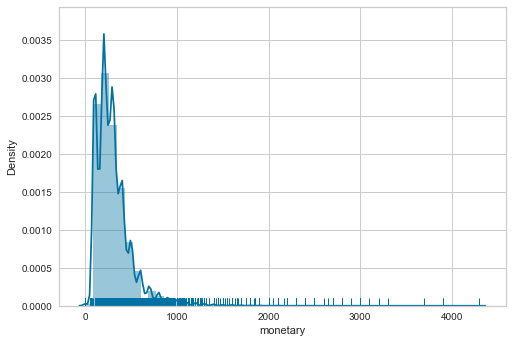

In [23]:
sns.distplot(df_rfm['monetary'], hist=True, rug=True)

У метрики monetary большой "хвост" справа, есть выбросы.

**2. Очистим данные от выбросов с помощью метода LocalOutlierFactor. Предварительно нормализуем данные.**

In [28]:
scaler = MinMaxScaler()

rfm_norm = pd.DataFrame(scaler.fit_transform(df_rfm.iloc[:, 0:3]))
rfm_norm.columns=['n_recency', 'n_frequency', 'n_monetary']

rfm_norm

,n_recency,n_frequency,n_monetary
0,0.376623,0.005650,0.087209
1,0.350649,0.007533,0.037209
2,0.116883,0.013183,0.049419
3,0.259740,0.000000,0.046512
4,0.649351,0.000000,0.023256
...,...,...,...
84536,0.090909,0.001883,0.046512
84537,0.000000,0.001883,0.023256
84538,0.103896,0.001883,0.220930
84539,0.012987,0.005650,0.093023


In [29]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(rfm_norm)
X_scores = clf.negative_outlier_factor_

df_rfm['score'] = X_scores

Чем меньше negative_outlier_factor_, тем сильнее выброс. Нормальные данные имеют negative_outlier_factor_ близкий к -1. В данном случае мы посчитали выбросами строки с negative_outlier_factor_ <= -2.

**Сохраним данные, которые алгоритм посчитал аномальными в отдельный датасет. Это пользователи, чье поведение сильно отличается от основной выборки - их можно исследовать отдельно.**

In [30]:
df_out = df_rfm[df_rfm['score'] <= -2]

df_out

,recency,frequency,monetary,score
user_client_id,,,,
000f69455e58ca24c10b419040ec885d52c90495,50,2,100.0,-2.824860e+06
002df81152cbded5be829fb8dd6a52c7911a5ea2,59,2,100.0,-5.649719e+06
00330900e4b6da1a8ff3064364026140321a1a40,58,3,300.0,-2.542374e+06
0044c6d44d3f01b2e2c26f9a12b41c137a67ec07,70,4,425.0,-3.130968e+07
0048270ff553655a6de324f0e5ffcc73d00f12fb,4,2,300.0,-3.766479e+06
...,...,...,...,...
ffcf0df5607d6c7fc9a45ffefc889fba1b0d53fd,43,2,300.0,-5.649719e+06
ffdc7a0c0297d9bb17517f5246da930bdbc15eba,43,2,300.0,-5.649719e+06
ffed08eb0280c2eb1a4f9ae9886e0750526a1a6e,45,3,100.0,-1.346516e+07


**Удалим выбросы из датасета**

In [31]:
df_rfm_clear = df_rfm[~df_rfm.index.isin(df_out.index)]

In [33]:
df_rfm_clear = df_rfm_clear[['recency', 'frequency', 'monetary']]

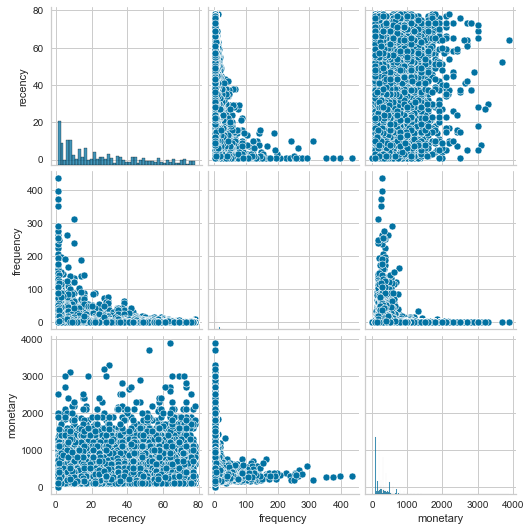

In [34]:
# Посмотрим на графике pairplot отношения между всеми парами метрик

sns.pairplot(df_rfm_clear)

In [36]:
# Посмотрим описательные статистики датасета

display(df_rfm_clear.describe())

,recency,frequency,monetary
count,77377.000000,77377.000000,77377.000000
mean,25.723742,5.059152,303.237848
std,21.896371,10.018462,211.563312
min,1.000000,1.000000,0.000000
25%,7.000000,1.000000,200.000000
50%,20.000000,2.000000,260.000000
75%,42.000000,5.000000,368.000000
max,78.000000,436.000000,3900.000000


<AxesSubplot:>

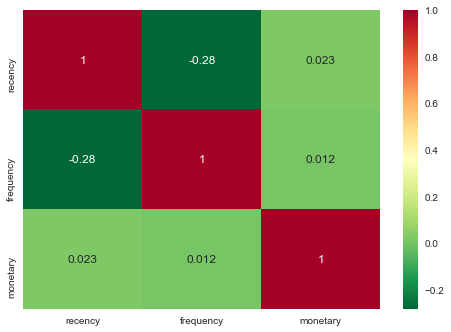

In [39]:
# Посмотрим на то, как метрики коррелируют друг с другом

sns.heatmap(df_rfm_clear.iloc[:, 0:3].corr(), annot=True, cmap='RdYlGn_r') 

Наблюдается слабая обратная корреляция между recency и frequency.

**3. Нормализуем данные**

In [41]:
scaler = MinMaxScaler()

rfm_norm = pd.DataFrame(scaler.fit_transform(df_rfm_clear.iloc[:, 0:3]))
rfm_norm.columns=['n_recency', 'n_frequency', 'n_monetary']
rfm_norm

,n_recency,n_frequency,n_monetary
0,0.376623,0.006897,0.096154
1,0.350649,0.009195,0.041026
2,0.116883,0.016092,0.054487
3,0.259740,0.000000,0.051282
4,0.649351,0.000000,0.025641
...,...,...,...
77372,0.090909,0.002299,0.051282
77373,0.000000,0.002299,0.025641
77374,0.103896,0.002299,0.243590
77375,0.012987,0.006897,0.102564


In [42]:
rfm_norm.describe()

,n_recency,n_frequency,n_monetary
count,77377.000000,77377.000000,77377.000000
mean,0.321088,0.009331,0.077753
std,0.284368,0.023031,0.054247
min,0.000000,0.000000,0.000000
25%,0.077922,0.000000,0.051282
50%,0.246753,0.002299,0.066667
75%,0.532468,0.009195,0.094359
max,1.000000,1.000000,1.000000


**4. Определим оптимальное число центроидов кластеров (k) с помощью метода колена**

<AxesSubplot:>

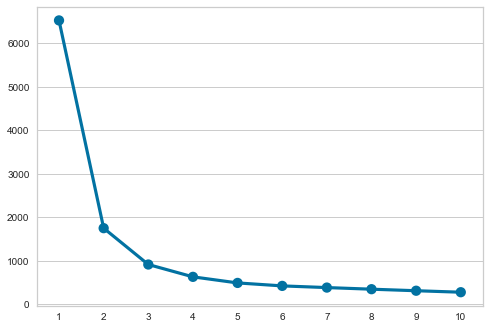

In [43]:
SSE = []

for k in range(0,10):
    kmeans = KMeans(n_clusters=k+1, random_state=1231).fit(rfm_norm)
    SSE.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,11)), y=SSE)

**Вывод:** на графике видно, что SSE падает сильно при увеличении числа кластеров с 1 до 2 и с 2 до 3 и уже не так сильно – при изменении k с 3 до 4. Попробуем построить силуэты для моделей с 4 и 5 кластерами.

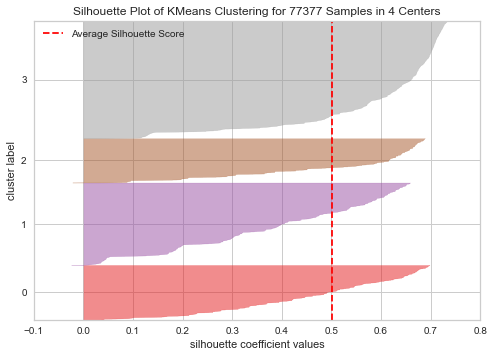

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 77377 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=4, random_state=42))

In [44]:
# Построим график силуэта
silhouette_visualizer(KMeans(4, random_state=42), rfm_norm)

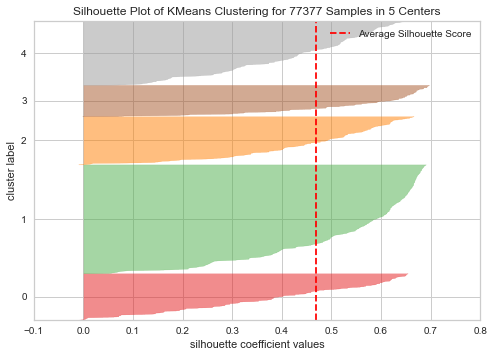

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 77377 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans(n_clusters=5, random_state=42))

In [45]:
# Проведём анализ силуетов кластеров и для n_clusters = 5

silhouette_visualizer(KMeans(5, random_state=42), rfm_norm)

**Вывод:** коэффициент силуэта (на графике помечен красной пунктирной линией) в случае разбиения на 5 кластеров ниже. Размеры кластеров также более сбалансированы.

**Построим 2 модели и выберем лучшую**

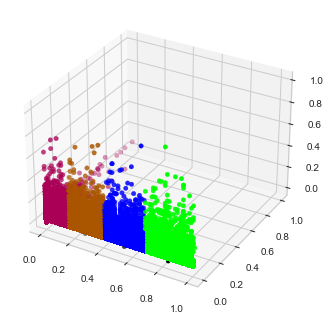

In [48]:
model = KMeans(n_clusters=4, random_state=1231).fit(rfm_norm)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_norm['n_recency'], rfm_norm['n_frequency'], rfm_norm['n_monetary'], cmap='brg',
          c=model.predict(rfm_norm))
ax.scatter(centers[:,0], centers[:,1], c='black');

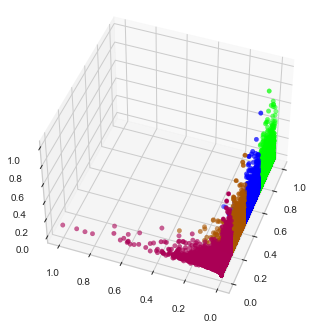

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_norm['n_recency'], rfm_norm['n_frequency'], rfm_norm['n_monetary'], cmap='brg',
          c=model.predict(rfm_norm))
ax.scatter(centers[:,0], centers[:,1], c='black')
ax.azim = 200
ax.elev = 45;

На графике видно, что границы кластеров нечеткие, особенно перемешаны 1 и 2 кластеры

**5. Рассмотрим получившиеся кластеры**

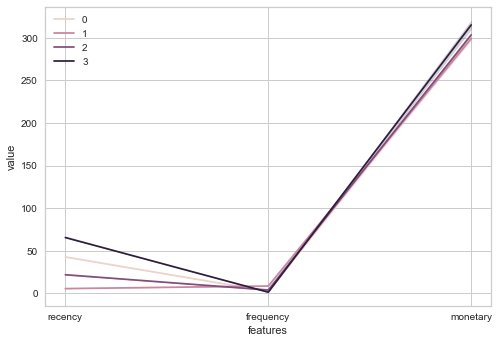

In [51]:
rfm_4 = pd.DataFrame(scaler.inverse_transform(rfm_norm))
rfm_4.columns = ['recency', 'frequency', 'monetary']
rfm_4['user_client_id'] = df_rfm_clear.index
rfm_4['cluster'] = model.labels_

melted_rfm_norm = pd.melt(rfm_4.reset_index(),
                         id_vars=['user_client_id', 'cluster'],
                         value_vars=['recency', 'frequency', 'monetary'],
                         var_name='features',
                         value_name='value')

sns.lineplot('features', 'value', hue='cluster', data = melted_rfm_norm)
plt.legend()

In [52]:
rfm_4.groupby('cluster').agg({
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean', 'max', 'min'],
    'monetary': ['mean', 'max', 'min', 'count']
})

recency             frequency                monetary          \
              mean   max   min      mean    max  min        mean     max   
cluster                                                                    
0        42.708947  54.0  33.0  2.317281   66.0  1.0  302.053538  3700.0   
1         5.547712  14.0   1.0  8.565277  436.0  1.0  299.155846  3100.0   
2        21.831194  32.0  14.0  3.882670  145.0  1.0  303.437310  3300.0   
3        65.536398  78.0  54.0  1.337761   16.0  1.0  315.178379  3900.0   

                       
           min  count  
cluster                
0        100.0  14183  
1          0.0  30401  
2        100.0  21350  
3        100.0  11443

По метрике recency датасет хорошо разбился на кластеры, по остальным метрикам. Особенно это хорошо видно на метрике monetary, по которой минимальные границы трёх из четырёх кластеров одинаковые.

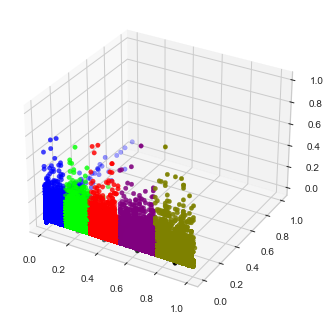

In [55]:
# построим модель с числом кластеров = 5
model = KMeans(n_clusters=5, random_state=1231).fit(rfm_norm)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_norm['n_recency'], rfm_norm['n_frequency'], rfm_norm['n_monetary'], cmap='brg',
          c=model.predict(rfm_norm))
ax.scatter(centers[:,0], centers[:,1], c='black');

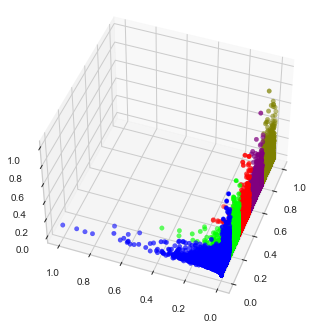

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_norm['n_recency'], rfm_norm['n_frequency'], rfm_norm['n_monetary'], cmap='brg',
          c=model.predict(rfm_norm))
ax.scatter(centers[:,0], centers[:,1], c='black')
ax.azim = 200
ax.elev = 45;

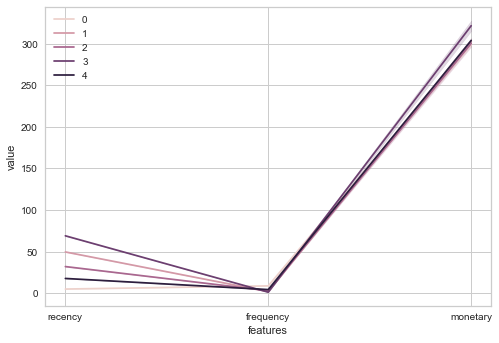

In [57]:
rfm_5 = pd.DataFrame(scaler.inverse_transform(rfm_norm))
rfm_5.columns = ['recency', 'frequency', 'monetary']
rfm_5['user_client_id'] = df_rfm_clear.index
rfm_5['cluster'] = model.labels_

melted_rfm_norm = pd.melt(rfm_5.reset_index(),
                         id_vars=['user_client_id', 'cluster'],
                         value_vars=['recency', 'frequency', 'monetary'],
                         var_name='features',
                         value_name='value')

sns.lineplot('features', 'value', hue='cluster', data = melted_rfm_norm)
plt.legend()

In [58]:
rfm_5.groupby('cluster').agg({
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean', 'max', 'min'],
    'monetary': ['mean', 'max', 'min', 'count']
})

recency             frequency                monetary          \
              mean   max   min      mean    max  min        mean     max   
cluster                                                                    
0         4.989470  11.0   1.0  8.808119  436.0  1.0  298.996116  3100.0   
1        49.620279  59.0  41.0  1.960156   44.0  1.0  302.790900  3700.0   
2        32.035238  40.0  25.0  2.981859   77.0  1.0  300.385984  3300.0   
3        69.023173  78.0  59.0  1.221866   12.0  1.0  321.664640  3900.0   
4        17.738283  24.0  12.0  4.367151  189.0  1.0  303.903945  3000.0   

                       
           min  count  
cluster                
0          0.0  28205  
1        100.0  12022  
2        100.0  12458  
3        100.0   8113  
4        100.0  16579

**Выводы:** 
- в обоих случаях алгоритм хорошо делит пользователей на кластеры только по метрике recency.
- разбивать по сразу по трём метрикам нецелесообразно, однако алгоритм (5 кластеров) четко выделил два кластера оттока: 1 (размером 12022 пользователя) и 3 (размером 8113 пользователя), а также характеристики этих пользователей по двум другим метрикам.
- оставим это разбиение на кластеры только для метрики recency и построим модели разбиения на кластеры для двух других метрик.

In [63]:
rfm_5 = rfm_5.rename({'cluster': 'cluster_recency'}, axis=1)

In [76]:
# Построим модель разбиения на 5 кластеров для метрики frequency

model = KMeans(n_clusters=5, random_state=1231).fit(rfm_norm[['n_frequency']])
centers = model.cluster_centers_

rfm_5_frequency = pd.DataFrame(scaler.inverse_transform(rfm_norm))
rfm_5_frequency.columns = ['recency', 'frequency', 'monetary']
rfm_5_frequency['user_client_id'] = df_rfm_clear.index
rfm_5_frequency['cluster'] = model.labels_

In [77]:
rfm_5_frequency.groupby('cluster').agg({
    'frequency': ['mean', 'max', 'min', 'count'],
})

frequency                     
               mean    max    min  count
cluster                                 
0          2.287064    7.0    1.0  64118
1         37.491689   65.0   26.0   1865
2         93.067568  177.0   66.0    296
3         12.790106   25.0    8.0  11077
4        270.190476  436.0  189.0     21

**Вывод:** кластеры получаются несбалансированными по размеру, зато границы (min и max) определяются хорошо. При такой градации мы можем вычленить пользователей, которые экстремально часто посещают раздел "Помощь" (кластер 4), часто (кластер 2) и т.д.

In [78]:
# Построим модель разбиения на 5 кластеров для метрики monetary

model = KMeans(n_clusters=5, random_state=1231).fit(rfm_norm[['n_monetary']])
centers = model.cluster_centers_

rfm_5_monetary = pd.DataFrame(scaler.inverse_transform(rfm_norm))
rfm_5_monetary.columns = ['recency', 'frequency', 'monetary']
rfm_5_monetary['user_client_id'] = df_rfm_clear.index
rfm_5_monetary['cluster'] = model.labels_

In [79]:
rfm_5_monetary.groupby('cluster').agg({
    'monetary': ['mean', 'max', 'min', 'count'],
})

monetary                                 
                mean          max          min  count
cluster                                              
0         539.914944   727.272727   430.769231   9493
1         321.264481   430.188679   240.540541  30025
2         159.337787   240.000000     0.000000  34819
3        1639.044315  3900.000000  1300.000000    496
4         916.394646  1275.000000   728.571429   2544

**Вывод:** при разбиении пользователей по метрике monetary кластеры более сбалансированы по размеру, чем при разбиении по метрике frequency. Пользователей с высокими тратами ожидаемо меньше.

**Сегментация пользователей по пересечению кластеров**

In [83]:
rfm_5_frequency = rfm_5_frequency.rename({'cluster': 'cluster_frequency'}, axis=1)
rfm_5_monetary = rfm_5_monetary.rename({'cluster': 'cluster_monetary'}, axis=1)
rfm_5_frequency = rfm_5_frequency[['user_client_id', 'cluster_frequency']]
rfm_5_monetary = rfm_5_monetary[['user_client_id', 'cluster_monetary']]

In [85]:
rfm = rfm_5.merge(rfm_5_monetary, on='user_client_id').merge(rfm_5_frequency, on='user_client_id')

In [86]:
rfm

,recency,frequency,monetary,user_client_id,cluster_recency,cluster_monetary,cluster_frequency
0,30.0,4.0,375.0,0001f3785a0a25569cde27e7f28f79dba66ca222,2,1,0
1,28.0,5.0,160.0,000243ad0488a501cd994670cc12fa7ae4edcde9,2,2,0
2,10.0,8.0,212.5,00026c5cdb25e2b03e3ce2f966614c026024a86b,0,2,3
3,21.0,1.0,200.0,000292735f714ba59c54d293f5725b32fbd91b7c,4,2,0
4,51.0,1.0,100.0,000297d8792259c0d1068ad4aa7abf8a200b8806,1,2,0
...,...,...,...,...,...,...,...
77372,8.0,2.0,200.0,fffc450c8d9a7e5ab49c6653ae820908a59373df,0,2,0
77373,1.0,2.0,100.0,fffe04bb9366c0759a7ce6b807f6c737acb01e47,0,2,0
77374,9.0,2.0,950.0,fffea59299f17b952db19dbd3e2a34c889ac4751,0,4,0
77375,2.0,4.0,400.0,fffee17278b00bf9b547a7d06239581b1674939a,0,1,0
